# PCA analysis

- TODO: [x] Regular PCA Vis.
- TODO: [x] Guided PCA Vis.

---
- 2021-04-13 first created
    - [x] PCA visualizations (speaker/vowel/rate)
    - [x] PCA gradient plot (speaker/pc)
- 2021-04-23
    - [x] Do Guided PCA analysis
- 2021-04-25
    - [x] Debug Guided PCA order (tongue factors)

In [1]:
%matplotlib inline
import os
import pickle
import re
import sys
from glob import glob
import itertools
import time

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image
from sklearn.ensemble import IsolationForest
from tqdm import notebook, tqdm

src_dir = '/home/jkang/project/Articulatory-Data-Processor'
sys.path.append(src_dir)
from tools.utils import *
from tools.plots import *
from tools.postproc import *
from tools.guided_pca import GuidedPCA

rand_seed = 0
flatten = itertools.chain.from_iterable

## Settings

In [2]:
# ----- Settings
save_again = True
plot_again = True
use_mel = True

# --- Directories
data_raw_dir = 'data'
data_proc_dir = 'data_processed'
data_plot_dir = 'data_plots'
stat_dir = 'stats'
gpca_file = os.path.join(data_proc_dir, 'gpca.pkl')

# data_file = os.path.join(data_proc_dir, 'data_2021-04-13.csv') # <----- UPDATE HERE (F1, F2 for Regular PCA 3D)
data_file = os.path.join(data_proc_dir, 'data_2021-04-27.csv') # <----- UPDATE HERE (F1, F2, F3 for Guided PCA 4D)

# --- Parameters
spkr_list = ['F01','F02','F03','F04','M01','M02','M03','M04']
vowel_list = ['IY1', 'IH1', 'EH1', 'AO1', 'AH1', 'AA1', 'AE1', 'UH1', 'UW1']
rate_list = ['N','F']
# acous_col = ['F1', 'F2']
acous_col = ['F1', 'F2', 'F3']

artic_col = ['TRx','TRz','TBx','TBz','TTx','TTz','JAWx','JAWz','ULx','ULz','LLx','LLz']
if use_mel:
    acous_col = [c + '_mel' for c in acous_col]
acous_col_norm = [re.sub('_mel', '_norm', ac) for ac in acous_col]
artic_col_norm = [ac+'_norm' for ac in artic_col]
pre_phone_poa = ['bilabial','alveolar','velar']
post_phone_poa = ['bilabial','alveolar','velar']

custom_vowels = ['IY1','IH1','EH1','AE1','AA1','UH1','UW1']
num_points = 9
vowel_mid_point = 0.5 # 0~1
corner_vowels = ['IY1', 'AE1', 'AA1', 'UW1']
vowel_label = ['i', 'ɪ', 'ɛ', 'ʌ', 'ɔ', 'ɑ', 'æ', 'ʊ', 'u']
custom_vowels = ['IY1','IH1','EH1','AE1']

vowel2ipa = {
    'IY1': 'i',
    'IH1': 'ɪ',
    'EH1': 'ɛ',
    'AO1': 'ʌ',
    'AH1': 'ɔ',
    'AA1': 'ɑ',
    'AE1': 'æ',
    'UH1': 'ʊ',
    'UW1': 'u',
}
num_pca = 3
num_gpca = 4
pca_col = ['PC1','PC2','PC3']
gpca_col = ['JAW','LIPS','vTNG','hTNG']
print('ready')

ready


In [3]:
# Rebuild fontmanager 
import matplotlib.font_manager as font_manager
font_manager._rebuild()

In [4]:
# Prepare data
D = pd.read_csv(data_file)
D.tail(3)

,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,PreVowelPOA,PostVowelPOA,Pronunciation,Tag,PlaceOfArticulation
140302,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.062283,0.127111,0.047193,0.040988,-0.027688,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
140303,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.035660,0.105324,-0.037390,0.069666,0.076274,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
140304,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,0.032341,0.138669,-0.149052,0.134113,0.268623,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial


In [5]:
# Load palate
pal_files = sorted(glob(os.path.join(data_raw_dir, '*.pkl')))
pal_all = load_palate(pal_files, spkr_list)
print("Loaded")

Loaded


In [6]:
# Load data parameters
with open(os.path.join(data_proc_dir, 'zscore.pkl'), 'rb') as pckl:
    Z = pickle.load(pckl)
with open(os.path.join(data_proc_dir, 'pca.pkl'), 'rb') as pckl:
    PC = pickle.load(pckl)
VT = pd.read_csv(os.path.join(data_proc_dir, 'vowel_targets.csv'))
GM = pd.read_csv(os.path.join(data_proc_dir, 'grand_means.csv'))
time_list = D.TimeAt.unique().tolist()
print('Loaded')

Loaded


## Gradient plot (PCA)

In [7]:
# Prepare data
lim = [-0.7, 0.7] # synthesis range
pca_col = ['PC1','PC2','PC3']
npc = len(pca_col)
nsample = 5
samples = np.linspace(lim[0], lim[1], nsample)
samples = np.round_(samples, decimals=2)
data = np.zeros((nsample*npc, npc))
data[nsample*0:nsample*1,0] = samples
data[nsample*1:nsample*2,1] = samples
data[nsample*2:nsample*3,2] = samples

Speaker = []
PC_col = []
SD_col = []
artic_data = np.zeros((len(spkr_list)*npc*nsample, len(artic_col)))

# Iterate over speakers
for i, which_spkr in tqdm(enumerate(spkr_list), total=len(spkr_list)):
    scaler = Scaler(which_spkr, Z)
    pca = PC[which_spkr]['pca']
    pal = pal_all[which_spkr]
    xdata = pca.inverse_transform(data)
    xdata = scaler.inverse_transform(xdata, 'artic')
    
    Speaker += [which_spkr]*npc*nsample
    PC_col += sorted(pca_col*nsample)
    SD_col += samples.tolist()*npc
    artic_data[npc*nsample*i:npc*nsample*(i+1),:] = xdata

PD = pd.DataFrame({
    'Speaker':Speaker,
    'PCA':PC_col,
    'SD':SD_col,
})
PD[artic_col] = pd.DataFrame(artic_data)
PD.head()

100%|██████████| 8/8 [00:00<00:00, 18714.13it/s]


,Speaker,PCA,SD,TRx,TRz,TBx,TBz,TTx,TTz,JAWx,JAWz,ULx,ULz,LLx,LLz
0,F01,PC1,-0.70,-48.892459,-3.362449,-33.565409,-0.370189,-15.956376,-11.657578,-5.335368,-25.510643,7.367924,4.881471,3.461754,-25.566707
1,F01,PC1,-0.35,-50.556593,-5.180071,-35.802343,-2.049806,-18.058517,-12.123426,-5.906964,-26.712953,7.649146,4.569645,3.232878,-26.484416
2,F01,PC1,0.00,-52.220727,-6.997693,-38.039277,-3.729423,-20.160657,-12.589273,-6.478561,-27.915262,7.930368,4.257818,3.004001,-27.402126
3,F01,PC1,0.35,-53.884861,-8.815315,-40.276212,-5.409040,-22.262797,-13.055121,-7.050157,-29.117572,8.211589,3.945992,2.775124,-28.319836
4,F01,PC1,0.70,-55.548995,-10.632937,-42.513146,-7.088657,-24.364938,-13.520968,-7.621753,-30.319881,8.492811,3.634166,2.546247,-29.237545


In [8]:
marker_types = ['circle', 'triangle_up', 'diamond']
colors = ['b', 'r', 'g']
ytick_lim = [-40, 20]
xtick_lim = [-80, 40]

# Visualize
if plot_again:
    sns.set_theme(style="whitegrid", rc={'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
    with sns.plotting_context(context='poster', font_scale=1):
        # Iterate over speakers
        for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
            explained = PC[which_spkr]['explained_variance_ratio_']
            fig, arr = plt.subplots(1, 3, facecolor='white', figsize=(24, 6))
            # Iterate over PCs
            for i, (ax, which_pc) in enumerate(zip(arr, pca_col)):
                ax = plot_palpha(ax, pal=pal_all[which_spkr], fontsize=20)
                lines = []
                # Iterate over SD
                for j, which_sd in enumerate(samples):
                    # Plot
                    ax = plot_artic(ax,
                                    PD.loc[(PD.Speaker == which_spkr) & (PD.PCA == which_pc) & (PD.SD == which_sd),
                                           artic_col].values,
                                    tongue_idx=[0, 1, 2, 3, 4, 5], jaw_idx=[6, 7], lip_idx=[8, 9, 10, 11],
                                    tongue_spline=True, markersize=(j+3)*1.3,
                                    override_color=[colors[i]]*3,
                                    markerfacecolor='none')
                    lines += [ax.get_lines()[-1]]
                ax.legend(lines, samples, fontsize='small', bbox_to_anchor=(1.03, 1))
                # Prettify
                ax.set_title(f'{which_pc} ({explained[i]*100:.1f}% explained)', fontsize=25)
                xticks = np.linspace(xtick_lim[0], xtick_lim[1], 7)
                ax.set_xticks([t for t in xticks])
                ax.set_xticklabels([f'{t:.0f}' for t in xticks])
                yticks = np.linspace(ytick_lim[0], ytick_lim[1], 7)
                ax.set_yticks([t for t in yticks])
                ax.set_yticklabels([f'{t:.0f}' for t in yticks])
            fig.suptitle(f'{which_spkr}', fontsize=35, y=0.9)
            fig.tight_layout()
            fig.savefig(os.path.join(data_plot_dir, which_spkr, f'{which_spkr}_pca_gradient.png'), bbox_inches='tight')
            plt.close()
    print('Saved')
else:
    print('Skipping')

  0%|          | 0/8 [00:00<?, ?it/s]findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
100%|██████████| 8/8 [00:03<00:00,  2.32it/s]

Saved


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

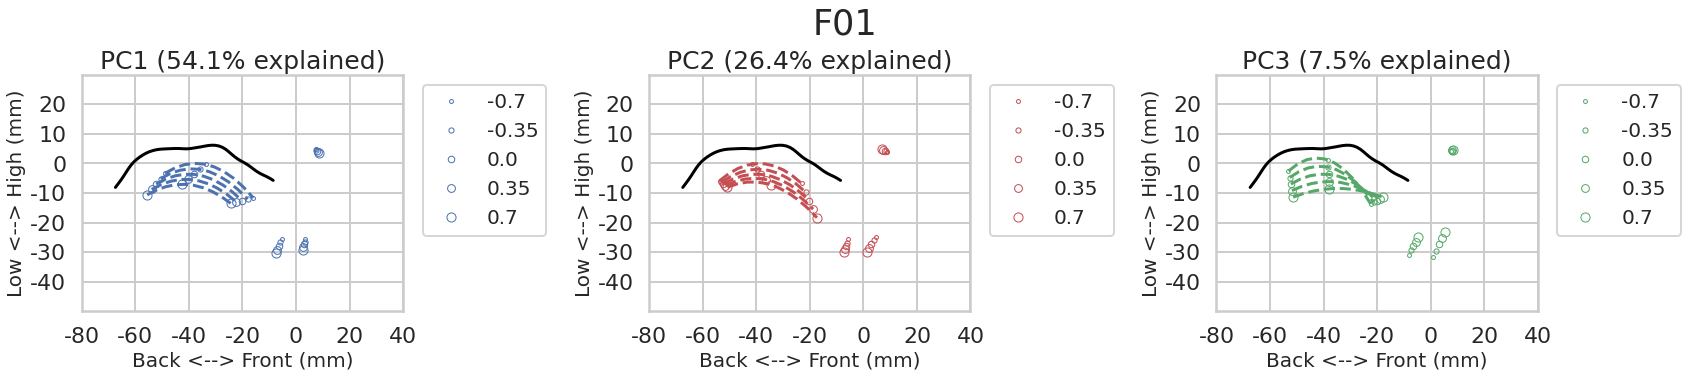

In [9]:
def func(which_spkr):
    return Image(filename=os.path.join(data_plot_dir, which_spkr, f'{which_spkr}_pca_gradient.png'), width=1000)

spkr_dropdown = widgets.Dropdown(options=spkr_list, value='F01')
interact(func, which_spkr=spkr_dropdown);
func('F01')

### PCA loading plot

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Saved


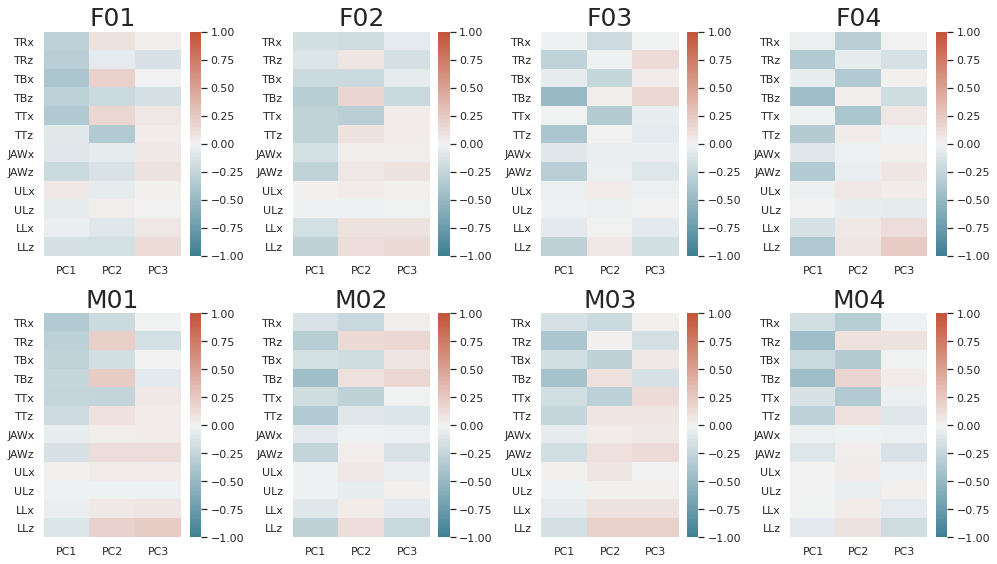

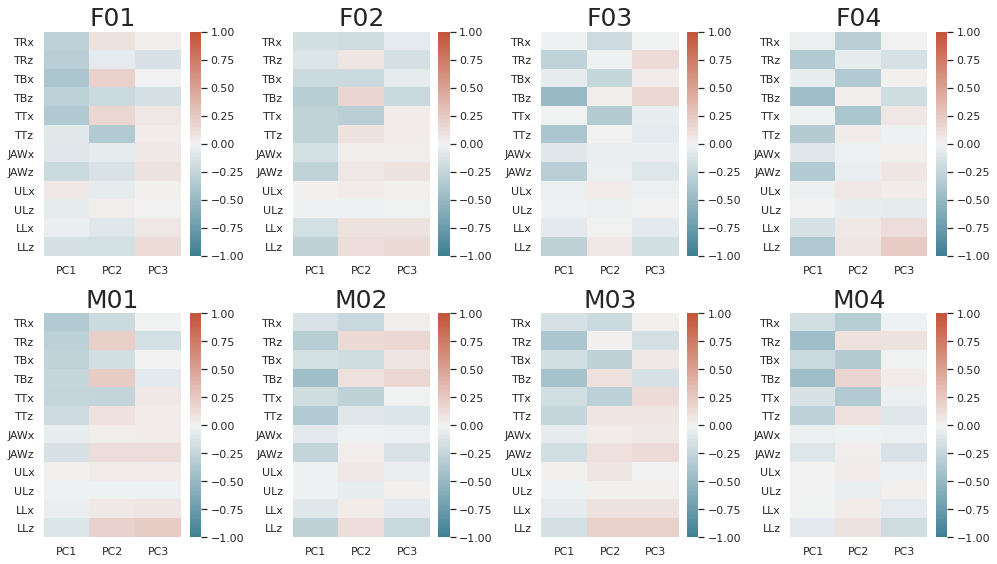

In [10]:
if plot_again:
    fig, arr = plt.subplots(2, 4, facecolor='white', figsize=(14, 8))
    for which_spkr, ax in zip(spkr_list, arr.flatten()):
        loadings = pd.DataFrame(PC[which_spkr]['pca'].components_.T * np.sqrt(PC[which_spkr]['pca'].explained_variance_),
                                columns=['PC1', 'PC2', 'PC3'],
                                index=artic_col)
        sns.heatmap(
            loadings,
            ax=ax,
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            #square=True
        )
        ax.set_title(which_spkr, fontsize=25)
    fig.tight_layout()
    fig.savefig(os.path.join(data_plot_dir, 'pca_loading_correlation.png'), bbox_inches='tight')
    print('Saved')

Image(filename=os.path.join(data_plot_dir, 'pca_loading_correlation.png'), width=1000)

## PCA pairwise plot

In [11]:
import io
import PIL

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

def _pairplot(df, var_list, rate_colors, npc, pca_lim, title_txt, ucm_space=None):
    g = sns.PairGrid(df, x_vars=var_list, y_vars=var_list,
                     hue='Rate', 
                     palette=rate_colors, corner=True)
    g = g.map_lower(sns.scatterplot, s=15, hue_order=rate_list)
    g = g.map_diag(sns.kdeplot, hue_order=rate_list, common_norm=False)
    g = g.add_legend()
    g.fig.set_size_inches(7,7)
    g.fig.set_facecolor('white')
    g._legend.set_bbox_to_anchor((0.8, 0.8))
    # Iterate over axes
    for i in range(npc): # row
        for j in range(npc): # column
            # Draw bounding box
            if (g.axes[i,j] is not None):
                for _, spine in g.axes[i,j].spines.items():
                    spine.set_visible(True)
                    spine.set_color('gray')
            if (i != j) & (g.axes[i,j] is not None):
                # Set axis
                g.axes[i,j].set_xlim(pca_lim)
                g.axes[i,j].set_ylim(pca_lim)
                # Add UCM
                if ucm_space is not None:
                    g.axes[i,j].plot(ucm_space[:,j], ucm_space[:,i], '-', lw=1, color='blue', alpha=0.5)
            # fix diag xlim, ylim
            if (i==j):
                g.axes[i,j].set_xlim(pca_lim)
                g.axes[i,j].set_xlabel('')
    g.fig.suptitle(title_txt, fontsize=25, y=1.07)
    return g

In [12]:
def _load_model_params(which_spkr, use_gpca):
    # Prepare palate
    pal = pal_all[which_spkr]

    # Initiate
    scaler = Scaler(which_spkr, Z)
    if use_gpca:
        pca = GPC[which_spkr]['gpca']
    else:
        pca = PC[which_spkr]['pca']
    return pal, scaler, pca


def _prep_data_for_ucm(which_spkr, which_vowel, which_rate, which_time, lim=[-0.5,0.5], nsample=5, use_gpca=False):
    # Prepare params
    pal, scaler, pca = _load_model_params(which_spkr, use_gpca)

    # Prepare original data
    if which_rate == 'NF':
        which_rate = ['N', 'F']
    else:
        which_rate = [which_rate]
    cond = ((D.Speaker==which_spkr)&
            (D.Vowel==which_vowel)&
            (D.TimeAt==which_time)&
            (D.Rate.isin(which_rate)))
    formants = D.loc[cond, acous_col].values
    artics = D.loc[cond, artic_col].values
    artics = scaler.transform(artics, 'artic')
    artics = pca.transform(artics).squeeze()
    
    median = (VT.loc[(VT.Speaker==which_spkr)&(VT.Vowel.isin(vowel_list))&(VT.TimeAt==which_time)]
              .sort_values(by='Vowel', key=lambda col: [vowel_list.index(v) for v in col.values])[acous_col]
              .values) # acous median

    # Get vowel-median artic data 
    #vdata = VT.loc[(VT.Speaker==which_spkr)&(VT.Vowel==which_vowel), artic_col].values
    vdata = D.loc[cond, artic_col].median(axis=0).values[np.newaxis,:]
    vdata = scaler.transform(vdata, 'artic')
    vdata = pca.transform(vdata).squeeze()
    init_pcs = vdata

    return init_pcs, median, pal, scaler, pca, artics, formants

### Visualize data onto PC space

In [13]:
which_time = 0.5
# which_model = 'all'
suffix = 'pca_space'
lim = [-20, 20]  # synthesis range
pca_lim = [-2.5,2.5]
nsample = 5
npc = 3
rate_colors = sns.color_palette('tab10', len(rate_list))

if plot_again:
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
    #for which_spkr in tqdm(['F01'], total=1):
        for which_vowel in vowel_list:
            # For NF together
            init_pcs, median, pal, scaler, pca, artics, formants = _prep_data_for_ucm(
                which_spkr, which_vowel, 'NF', which_time,  # conditions
                lim=lim, nsample=nsample)
            # For N rate
            _, _, _, _, _, artics_N, formants_N = _prep_data_for_ucm(
                which_spkr, which_vowel, 'N', which_time,  # conditions
                lim=lim, nsample=nsample)
            # For F rate
            _, _, _, _, _, artics_F, formants_F = _prep_data_for_ucm(
                which_spkr, which_vowel, 'F', which_time,  # conditions
                lim=lim, nsample=nsample)

            # Make sure to center artics by substracting init_pcs
            artics_raw = np.vstack([artics_F, artics_N])
            artics_centered = artics_raw - init_pcs

            NF = pd.DataFrame({
                'PC1': artics_raw[:,0],
                'PC2': artics_raw[:,1],
                'PC3': artics_raw[:,2],
            })
            NF['Speaker'] = which_spkr
            NF['Vowel'] = which_vowel
            NF['Rate'] = ['F']*(artics_F.shape[0]) + ['N']*(artics_N.shape[0]) # this changed plotting zorder!!

            # Plot
            sns.set_theme(context='paper', style='whitegrid', 
                          rc={'legend.fontsize': 20, 
                              'legend.title_fontsize': 20,
                              'axes.labelsize': 20})
            # ----- Original data
            h = _pairplot(NF, ['PC1','PC2','PC3'], rate_colors, npc, pca_lim, 'Data', ucm_space=None)

            # Combine
            img1 = fig2img(h)
            max_width = img1.size[0]
            max_height = img1.size[1]
            new_img = PIL.Image.new('RGB', (max_width, max_height))
            x_offset = 0
            new_img.paste(img1, (0,0))
            new_img.save(os.path.join(data_plot_dir, which_spkr, f'{which_spkr}_{which_vowel}_{suffix}.png'))

            # clean up
            img1.close()
            new_img.close()
            plt.close('all')
    print('Saved') # ~ 10 min
else:
    print('Skipping')

100%|██████████| 8/8 [01:13<00:00,  9.22s/it]

Saved


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

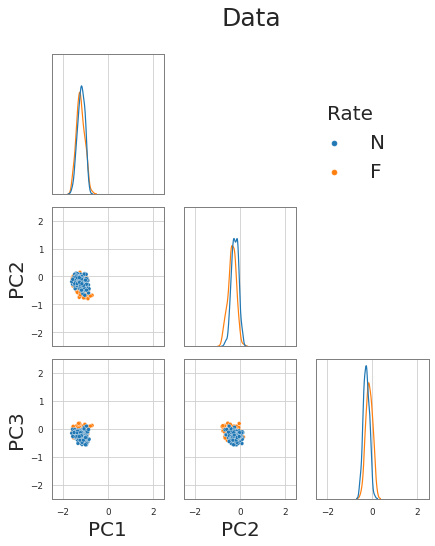

In [14]:
def func3(which_spkr, which_vowel):
    return Image(filename=os.path.join(data_plot_dir, which_spkr, f'{which_spkr}_{which_vowel}_{suffix}.png'), width=500)

spkr_dropdown3 = widgets.Dropdown(options=spkr_list, value='F01')
vowel_dropdown3 = widgets.Dropdown(options=vowel_list, value='IY1')
interact(func3, which_spkr=spkr_dropdown3, which_vowel=vowel_dropdown3);
func3('F01', 'IY1')

---

## Guided PCA
- Do Guided PCA analysis
- Visualize PCs

In [15]:
factor_matrix = np.array([
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],  # factor1: JAWx, JAWy
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],  # factor2: ULx,ULy,LLx,LLy
    [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],  # factor3: T1y,T2y,T3y
    [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # factor4: T1x,T2x,T3x
#     [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # factor4: T1x,T2x,T3x
#     [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # factor4: T1x,T2x,T3x
#     [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],  # factor3: T1y,T2y,T3y
#     [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # factor4: T1x,T2x,T3x
#     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # factor3: T1y,T2y,T3y
])

### Do Guided PCA analysis

In [16]:
# Save

######## CHANGE HERE ########
save_again = True

if save_again:
    which_rate = 'N'
    which_time = 0.5
    GPC = {}
    for i in tqdm(range(len(spkr_list))):
        spkr = spkr_list[i]
        data = D.loc[(D.Speaker==spkr)&(D.TimeAt==which_time)&(D.Rate==which_rate), artic_col].values
        scaler = Scaler(spkr, Z)
        zdata = scaler.transform(data, 'artic')

        # Guided PCA
        gpca = GuidedPCA(factor_matrix, 
                         n_components=num_gpca,
                         #n_components=5,
                        )
        gpca.fit(zdata)
        GPC.update({
            spkr: {
                'gpca': gpca,
                'components': gpca.components_,
                'explained_variance_ratio_': gpca.explained_variance_ratio_.tolist(),
                #'singular_values_': gpca.singular_values_.tolist(),
                'info': f'guided pca, extracted {get_date()}'}})

    # Save
    with open(os.path.join(gpca_file), 'wb') as pckl:
        pickle.dump(GPC, pckl)
    print(os.path.join(gpca_file), 'Saved')
else:
    # If parameters are saved before, just load it!
    with open(os.path.join(gpca_file), 'rb') as pckl:
        GPC = pickle.load(pckl)
    print(os.path.join(gpca_file), 'Loaded')

100%|██████████| 8/8 [00:00<00:00, 43.95it/s]

data_processed/gpca.pkl Saved


- amount variability explained

In [17]:
# Check variance explained
avg = 0
for which_spkr in spkr_list:
    ratios = GPC[which_spkr]['explained_variance_ratio_']
    #ratios_perc = [f'{r*100:.0f} %' for r in ratios]
    avg += ratios
    print(f'{which_spkr}: {ratios*100:.0f}%')
print(f'==> Average: {avg/len(spkr_list)*100:.2f} %')

F01: 82%
F02: 83%
F03: 87%
F04: 92%
M01: 84%
M02: 83%
M03: 87%
M04: 92%
==> Average: 86.21 %


### Visualize Guided PCs

- Move only each component and reconstruct

In [18]:
def _validate_gpca_by_reconstruction(df, which_spkr, which_rate, which_vowel, which_time, artic_col, artic_col_norm, GPC, Z):
    gpca = GPC[which_spkr]['gpca']
    scaler = Scaler(which_spkr, Z)
    d = df.loc[(df.Speaker == which_spkr) & (df.Rate == which_rate) & (
        df.Vowel == which_vowel) & (df.TimeAt == which_time), artic_col]
    dn = df.loc[(df.Speaker == which_spkr) & (df.Rate == which_rate) & (
        df.Vowel == which_vowel) & (df.TimeAt == which_time), artic_col_norm]

    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(18, 5), facecolor='white')

    # Original data
    plot_palpha(ax1, pal_all[which_spkr], pha=None)
    plot_artic_df(ax1, d, ['TRx', 'TBx', 'TTx'], ['TRz', 'TBz', 'TTz'], ['JAWx'], [
                  'JAWz'], ['ULx', 'LLx'], ['ULz', 'LLz'], tongue_spline=True)
    ax1.set_title('Original', fontsize=25)

    # Normalized data
    plot_artic_df(ax2, dn, ['TRx_norm', 'TBx_norm', 'TTx_norm'],
                  ['TRz_norm', 'TBz_norm', 'TTz_norm'],
                  ['JAWx_norm'], ['JAWz_norm'],
                  ['ULx_norm', 'LLx_norm'], ['ULz_norm', 'LLz_norm'], tongue_spline=True)
    ax2.set_xlim([-2, 2])
    ax2.set_ylim([-2, 2])
    ax2.set_title('Normalized', fontsize=25)

    # Reconstructed data
    dz = dn.values
    dz = gpca.transform(dz)
    dz = gpca.inverse_transform(dz)
    dz = scaler.inverse_transform(dz, 'artic')
    dnz = dn.copy()
    dnz[artic_col] = dz
    plot_palpha(ax3, pal_all[which_spkr], pha=None)
    plot_artic_df(ax3, dnz, ['TRx', 'TBx', 'TTx'], ['TRz', 'TBz', 'TTz'], [
                  'JAWx'], ['JAWz'], ['ULx', 'LLx'], ['ULz', 'LLz'], tongue_spline=True)
    ax3.set_title('Reconstructed', fontsize=25)
    plt.suptitle(f'{which_spkr}, {which_vowel}', fontsize=30, y=1.05)
    return fig, (ax1, ax2, ax3)

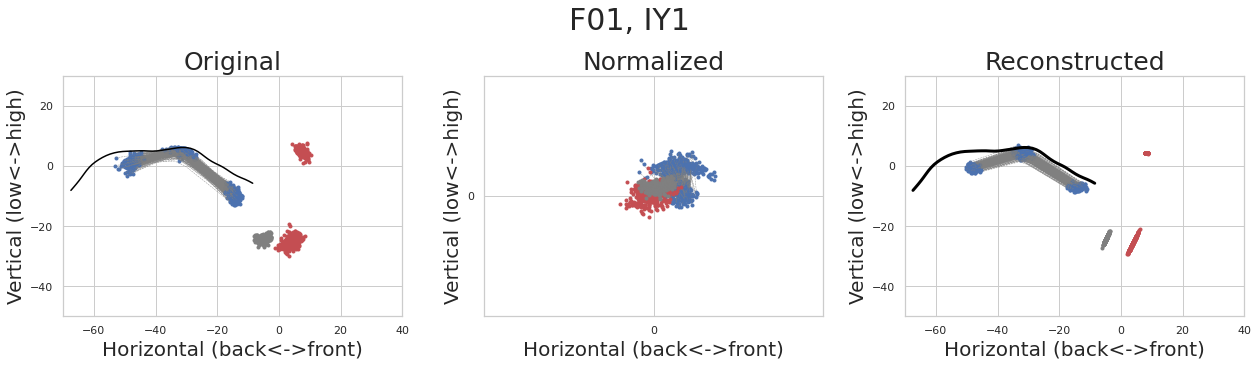

In [19]:
which_spkr = 'F01'
which_vowel = 'IY1'
which_rate = 'N'
which_time = 0.5

with sns.plotting_context(context='paper'):
    sns.set_theme(style='whitegrid')
    fig, arr = _validate_gpca_by_reconstruction(D, which_spkr, which_rate, which_vowel, which_time, artic_col, artic_col_norm, GPC, Z)

### Add GPC columns to data

In [20]:
D[gpca_col] = 0

for which_spkr in spkr_list:
    condition = (D.Speaker==which_spkr)
    scaler = Scaler(which_spkr, Z)
    gpca = GPC[which_spkr]['gpca']
    
    d = D.loc[condition, artic_col].values
    d = scaler.transform(d, 'artic')
    d = gpca.transform(d)
    D.loc[condition, gpca_col] = d
#     D.loc[condition, gpca_col+['RES']] = d
print('Done')

Done


In [21]:
D.columns

Index(['Token', 'FileID', 'Speaker', 'Block', 'Rate', 'Sent', 'Rep', 'Word',
       'PreVowel', 'Vowel', 'PostVowel', 'Duration', 'TimeAt', 'TimeSec', 'F1',
       'F2', 'F3', 'TRx', 'TRz', 'TBx', 'TBz', 'TTx', 'TTz', 'JAWx', 'JAWz',
       'ULx', 'ULz', 'LLx', 'LLz', 'F1_mel', 'F2_mel', 'F3_mel', 'AcousVar',
       'ArticVar', 'RescaleFactorAcous', 'RescaleFactorArtic', 'F1_grandmean',
       'F2_grandmean', 'F3_grandmean', 'F1_norm', 'F2_norm', 'F3_norm',
       'TRx_norm', 'TRz_norm', 'TBx_norm', 'TBz_norm', 'TTx_norm', 'TTz_norm',
       'JAWx_norm', 'JAWz_norm', 'ULx_norm', 'ULz_norm', 'LLx_norm',
       'LLz_norm', 'PreVowelPOA', 'PostVowelPOA', 'Pronunciation', 'Tag',
       'PlaceOfArticulation', 'JAW', 'LIPS', 'vTNG', 'hTNG'],
      dtype='object')

### Gradient Plot (Guided PCA)

In [22]:
gpca_col

['JAW', 'LIPS', 'vTNG', 'hTNG']

In [23]:
# Prepare data
lim = [-0.5, 0.5] # synthesis range
npc = len(gpca_col)
# npc = len(gpca_col+['RES'])
nsample = 5
samples = np.linspace(lim[0], lim[1], nsample)
data = np.zeros((nsample*npc, npc))
data[nsample*0:nsample*1,0] = samples
data[nsample*1:nsample*2,1] = samples
data[nsample*2:nsample*3,2] = samples
data[nsample*3:nsample*4,3] = samples
# data[nsample*4:nsample*5,4] = samples

Speaker = []
PC_col = []
SD_col = []
artic_data = np.zeros((len(spkr_list)*npc*nsample, len(artic_col)))

# Iterate over speakers
for i, which_spkr in tqdm(enumerate(spkr_list), total=len(spkr_list)):
    scaler = Scaler(which_spkr, Z)
    gpca = GPC[which_spkr]['gpca']  
    pal = pal_all[which_spkr]
    xdata = gpca.inverse_transform(data)
    xdata = scaler.inverse_transform(xdata, 'artic')
    
    Speaker += [which_spkr]*npc*nsample
    PC_col += sorted(gpca_col*nsample)
#     PC_col += sorted((gpca_col+['RES'])*nsample)
    SD_col += samples.tolist()*npc
    artic_data[npc*nsample*i:npc*nsample*(i+1),:] = xdata

PD = pd.DataFrame({
    'Speaker':Speaker,
    'PCA':PC_col,
    'SD':SD_col,
})
PD[artic_col] = pd.DataFrame(artic_data)
PD.head()

100%|██████████| 8/8 [00:00<00:00, 9248.74it/s]


,Speaker,PCA,SD,TRx,TRz,TBx,TBz,TTx,TTz,JAWx,JAWz,ULx,ULz,LLx,LLz
0,F01,JAW,-0.50,-52.220727,-6.997693,-38.039277,-3.729423,-20.160657,-12.589273,-3.765133,-21.893273,7.930368,4.257818,3.004001,-27.402126
1,F01,JAW,-0.25,-52.220727,-6.997693,-38.039277,-3.729423,-20.160657,-12.589273,-5.121847,-24.904268,7.930368,4.257818,3.004001,-27.402126
2,F01,JAW,0.00,-52.220727,-6.997693,-38.039277,-3.729423,-20.160657,-12.589273,-6.478561,-27.915262,7.930368,4.257818,3.004001,-27.402126
3,F01,JAW,0.25,-52.220727,-6.997693,-38.039277,-3.729423,-20.160657,-12.589273,-7.835275,-30.926257,7.930368,4.257818,3.004001,-27.402126
4,F01,JAW,0.50,-52.220727,-6.997693,-38.039277,-3.729423,-20.160657,-12.589273,-9.191989,-33.937252,7.930368,4.257818,3.004001,-27.402126


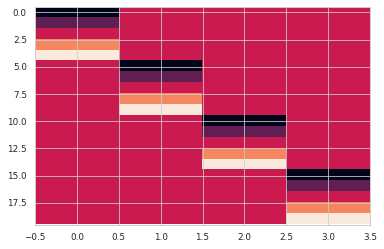

In [24]:
plt.imshow(data, aspect='auto')

100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


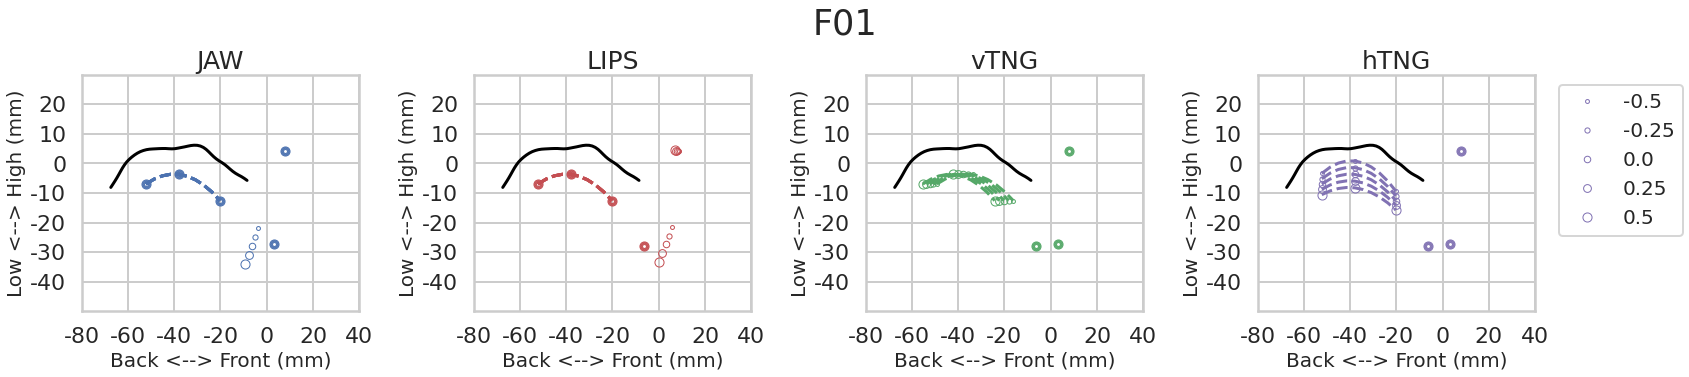

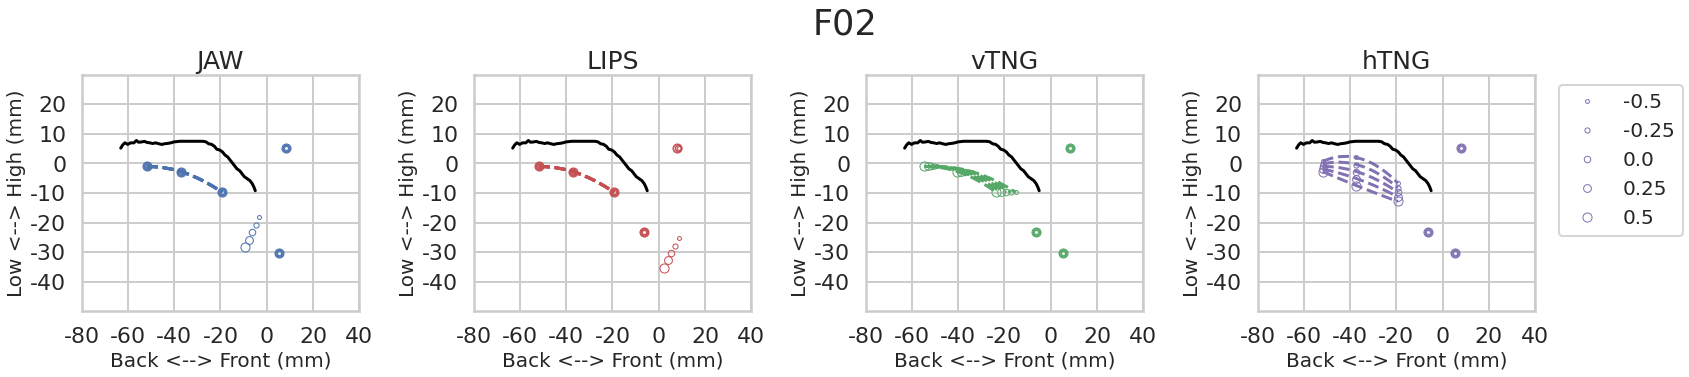

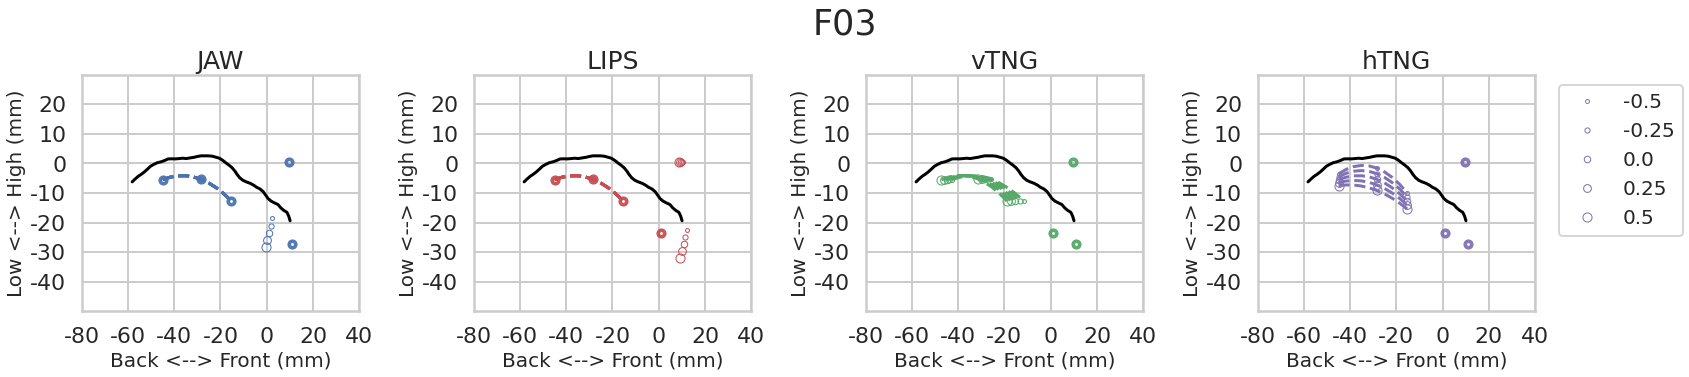

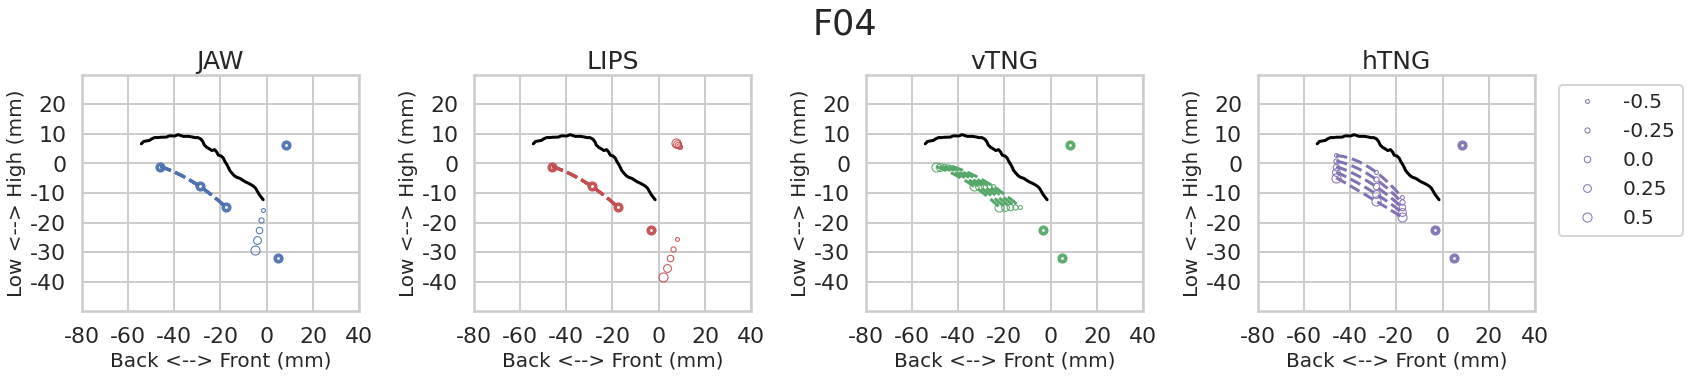

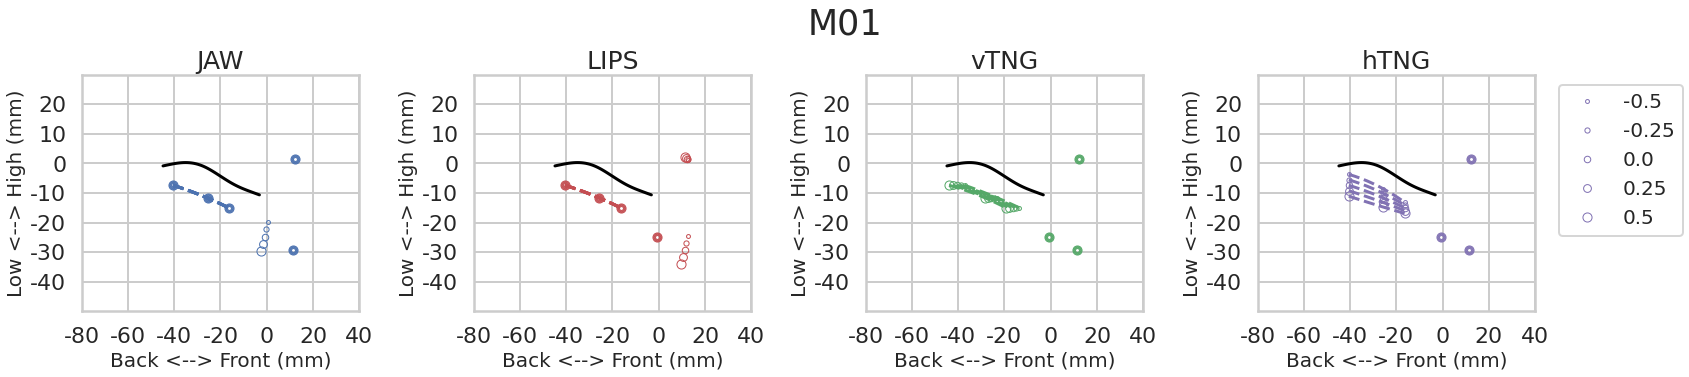

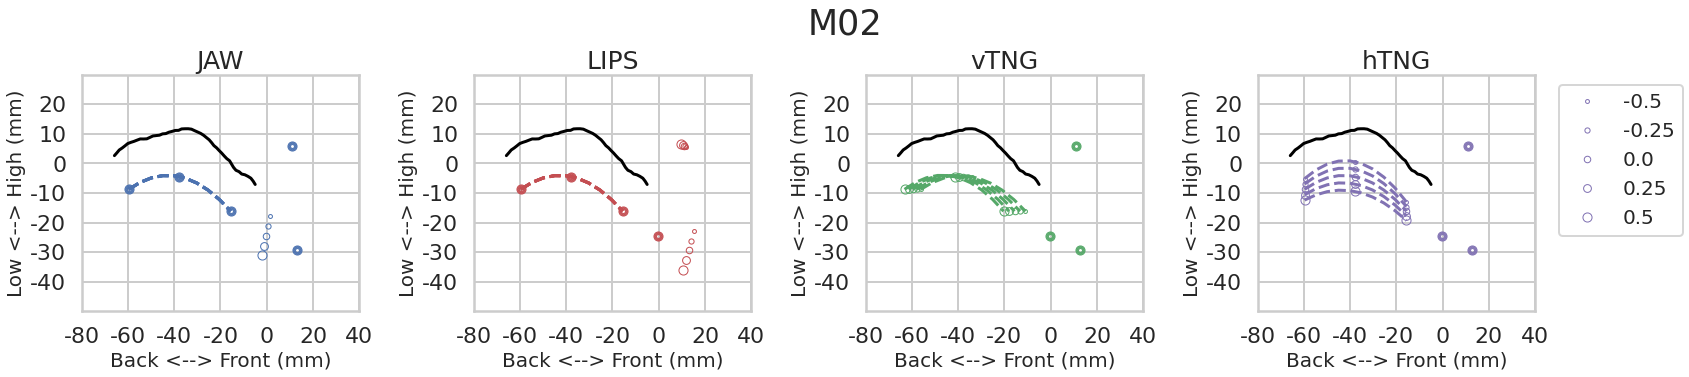

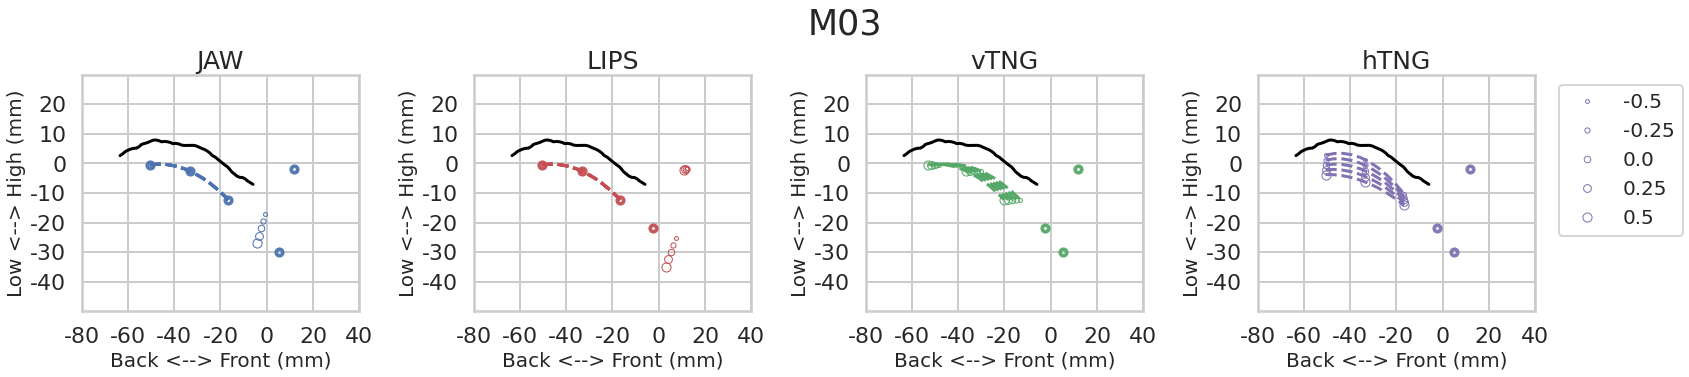

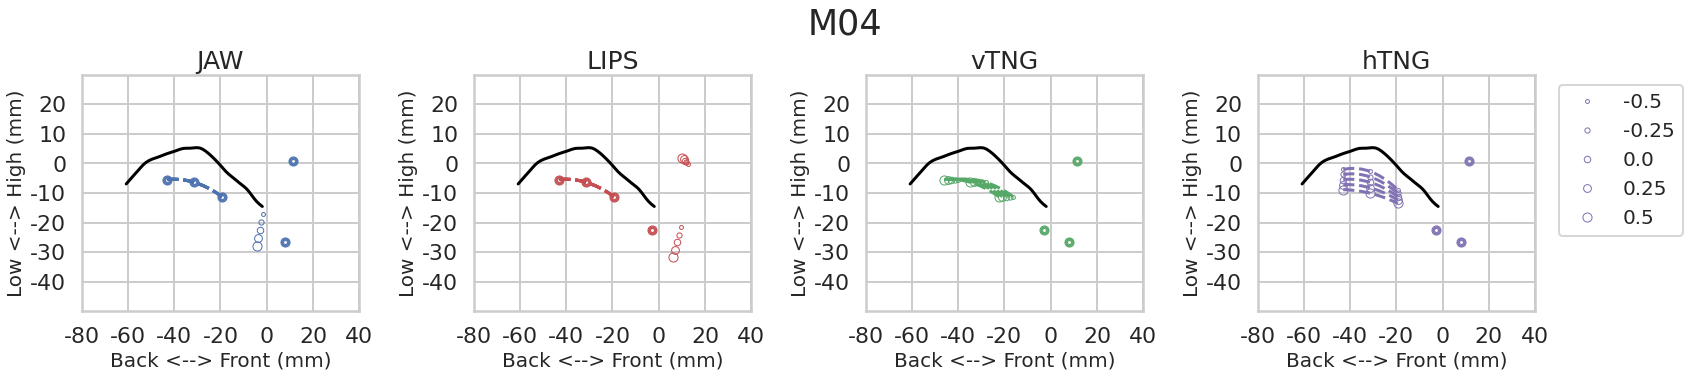

In [25]:
marker_types = ['circle', 'triangle_up', 'diamond']
colors = ['b', 'r', 'g', 'm','y']
ytick_lim = [-40, 20]
xtick_lim = [-80, 40]

# Visualize
# sns.set_theme(style="whitegrid", rc={'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
with sns.plotting_context(context='poster', font_scale=1):
    
    # Iterate over speakers
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
        explained = GPC[which_spkr]['explained_variance_ratio_']
        fig, arr = plt.subplots(1, 
                                num_gpca, 
                                #5,
                                facecolor='white', figsize=(24, 6))
        # Iterate over PCs
        for i, (ax, which_pc) in enumerate(zip(arr.flatten(), gpca_col)):
            ax = plot_palpha(ax, pal=pal_all[which_spkr], fontsize=20)
            lines = []
            # Iterate over SD
            for j, which_sd in enumerate(samples):
                # Plot
                ax = plot_artic(ax,
                                PD.loc[(PD.Speaker == which_spkr) & (PD.PCA == which_pc) & (PD.SD == which_sd),
                                       artic_col].values,
                                tongue_idx=[0, 1, 2, 3, 4, 5], jaw_idx=[6, 7], lip_idx=[8, 9, 10, 11],
                                tongue_spline=True, markersize=(j+3)*1.3,
                                override_color=[colors[i]]*3,
                                markerfacecolor='none')
                lines += [ax.get_lines()[-1]]
            # Add legend only at the final plot
            if i == len(gpca_col) - 1:
                ax.legend(lines, samples, fontsize='small', bbox_to_anchor=(1.05, 1))
            # Prettify
            ax.set_title(f'{which_pc}', fontsize=25)
            xticks = np.linspace(xtick_lim[0], xtick_lim[1], 7)
            ax.set_xticks([t for t in xticks])
            ax.set_xticklabels([f'{t:.0f}' for t in xticks])
            yticks = np.linspace(ytick_lim[0], ytick_lim[1], 7)
            ax.set_yticks([t for t in yticks])
            ax.set_yticklabels([f'{t:.0f}' for t in yticks])
        fig.suptitle(f'{which_spkr}', fontsize=35, y=0.9)
        fig.tight_layout()

        if save_again:
            fig.savefig(os.path.join(data_plot_dir, which_spkr, f'{which_spkr}_gpca_gradient.png'), bbox_inches='tight')
            #plt.close()

# TODO: 여서부터 다시!! 왜 PC3과 PC4가 반대로 나오는지 확인할 것!!!
- x와 z의 좌표가 바뀐 것 같은데, 명확히 왜 그런지 모르겠다
- 이 부분 나중에 다시 점검할 것

## Visualize data onto each PC space

In [26]:
custom_vowels

['IY1', 'IH1', 'EH1', 'AE1']

100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


Saved


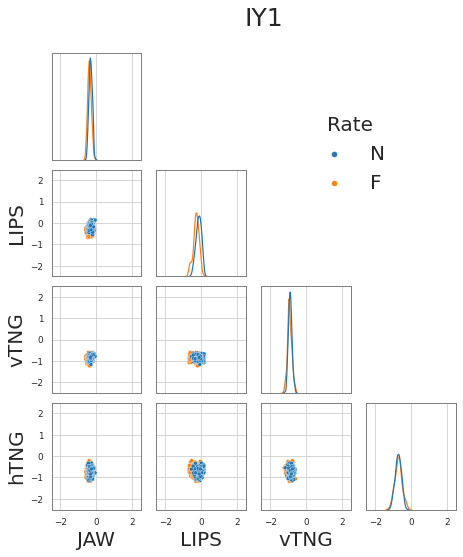

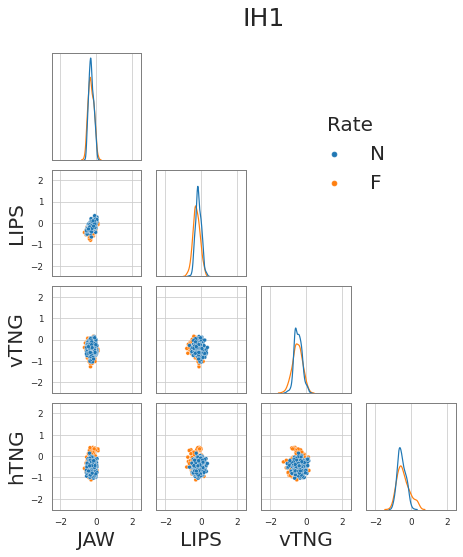

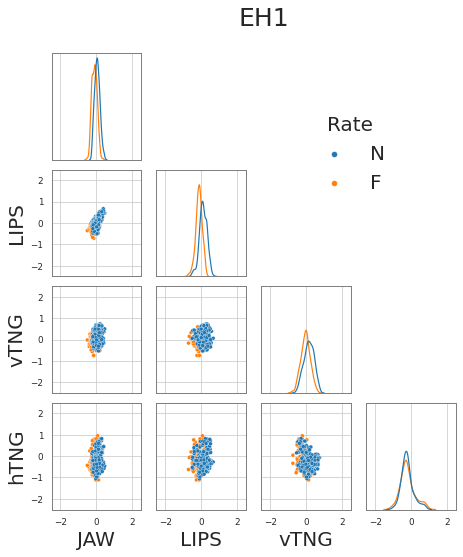

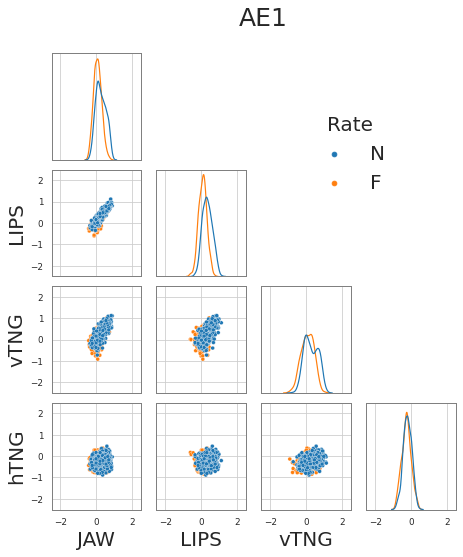

In [27]:
which_time = 0.5
# which_model = 'all'
suffix = 'gpca_space'
lim = [-20, 20]  # synthesis range
pca_lim = [-2.5,2.5]
nsample = 5
npc = num_gpca
# npc = 3
rate_colors = sns.color_palette('tab10', len(rate_list))

if plot_again:
#     for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
    for which_spkr in tqdm(['F01'], total=1):
        for which_vowel in custom_vowels:
            # For NF together
            init_pcs, median, pal, scaler, pca, artics, formants = _prep_data_for_ucm(
                which_spkr, which_vowel, 'NF', which_time,  # conditions
                lim=lim, nsample=nsample, use_gpca=True)
            # For N rate
            _, _, _, _, _, artics_N, formants_N = _prep_data_for_ucm(
                which_spkr, which_vowel, 'N', which_time,  # conditions
                lim=lim, nsample=nsample, use_gpca=True)
            # For F rate
            _, _, _, _, _, artics_F, formants_F = _prep_data_for_ucm(
                which_spkr, which_vowel, 'F', which_time,  # conditions
                lim=lim, nsample=nsample, use_gpca=True)

            # Make sure to center artics by substracting init_pcs
            artics_raw = np.vstack([artics_F, artics_N])
            artics_centered = artics_raw - init_pcs

            NF = pd.DataFrame({
                'JAW': artics_raw[:,0],
                'LIPS': artics_raw[:,1],
                'vTNG': artics_raw[:,2],
                'hTNG': artics_raw[:,3],
            })
            NF['Speaker'] = which_spkr
            NF['Vowel'] = which_vowel
            NF['Rate'] = ['F']*(artics_F.shape[0]) + ['N']*(artics_N.shape[0]) # this changed plotting zorder!!

            # Plot
            sns.set_theme(context='paper', style='whitegrid', 
                          rc={'legend.fontsize': 20, 
                              'legend.title_fontsize': 20,
                              'axes.labelsize': 20})
            # ----- Original data
            h = _pairplot(NF, gpca_col, rate_colors, npc, pca_lim, which_vowel, ucm_space=None)

            # Combine
            img1 = fig2img(h)
            max_width = img1.size[0] * 3
            max_height = img1.size[1]
            new_img = PIL.Image.new('RGB', (max_width, max_height))
            x_offset = 0
            new_img.paste(img1, (0,0))
            new_img.save(os.path.join(data_plot_dir, which_spkr, f'{which_spkr}_{which_vowel}_{suffix}.png'))

            # clean up
            img1.close()
            new_img.close()
            #plt.close('all')
    print('Saved') # ~ 10 min
else:
    print('Skipping')

---

## Statistics

In [28]:
%load_ext rpy2.ipython

In [29]:
%%R
# Stat
library(car)
library(stats)
library(lme4)
library(emmeans)

# Plotting
library(ggplot2)
library(ggeffects)
library(ggpubr)
library(sjPlot)

R[write to console]: Loading required package: carData

R[write to console]: Loading required package: Matrix

R[write to console]: Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

R[write to console]: Learn more about the underlying theory at https://ggplot2-book.org/

R[write to console]: Install package "strengejacke" from GitHub (`devtools::install_github("strengejacke/strengejacke")`) to load all sj-packages at once!



#### Fix plot font issue

In [65]:
%%capture
%%R
par(family  = "Arial")
install.packages("showtext")
library(showtext)
showtext_auto()

### (1) LME model when DV: JAW

In [66]:
d = D.loc[D.Vowel.isin(['IY1','IH1','EH1','AE1'])].reset_index(drop=True)
print(d.shape)

(75340, 63)


In [67]:
%%R -i d
d$Rate = as.factor(d$Rate)
d$Vowel = as.factor(d$Vowel)
d$PreVowel = as.factor(d$PreVowel)
d$Speaker = as.factor(d$Speaker)
d$Block = as.factor(d$Block)
d$Token = as.factor(d$Token)
d$PreVowelPOA = as.factor(d$PreVowelPOA)
d$PostVowelPOA = as.factor(d$PostVowelPOA)

d$Vowel <- ordered(d$Vowel, levels = c("IY1", "IH1", "EH1", "AE1"))
d$PreVowelPOA = ordered(d$PreVowelPOA, levels=c("bilabial","alveolar","velar","pharyngeal"))

In [68]:
%%R
m.JAW = lmer(JAW ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
summary(m.JAW)

Linear mixed model fit by REML ['lmerMod']
Formula: JAW ~ Rate * PreVowelPOA * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: -13460.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4346 -0.5857 -0.0493  0.5322  7.7677 

Random effects:
 Groups   Name        Variance Std.Dev.
 Speaker  (Intercept) 0.001215 0.03486 
 Residual             0.043641 0.20890 
Number of obs: 46790, groups:  Speaker, 8

Fixed effects:
                             Estimate Std. Error t value
(Intercept)                 -0.133636   0.012526 -10.668
RateN                        0.073805   0.002886  25.576
PreVowelPOA.L                0.004282   0.004186   1.023
PreVowelPOA.Q                0.050610   0.004465  11.336
PreVowelPOA.C               -0.073779   0.004725 -15.614
Vowel.L                      0.293172   0.004826  60.745
Vowel.Q                      0.069019   0.004467  15.450
Vowel.C                     -0.033023   0.004071  -8.112
RateN:PreVowelPOA.L          0.034301

R[write to console]: 
Correlation matrix not shown by default, as p = 32 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [69]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.JAW, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: JAW
                          Chisq Df Pr(>Chisq)    
(Intercept)             113.813  1  < 2.2e-16 ***
Rate                    654.141  1  < 2.2e-16 ***
PreVowelPOA            1068.107  3  < 2.2e-16 ***
Vowel                  5979.585  3  < 2.2e-16 ***
Rate:PreVowelPOA         62.438  3  1.771e-13 ***
Rate:Vowel              279.041  3  < 2.2e-16 ***
PreVowelPOA:Vowel       195.446  9  < 2.2e-16 ***
Rate:PreVowelPOA:Vowel   42.657  9  2.492e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [70]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.JAW = emmeans(m.JAW, ~ Rate|Vowel, adjust = "tukey")
pairs(em.JAW)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46790' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46790' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0432 0.00788 Inf  -5.480 <.0001 

Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0215 0.00469 Inf  -4.573 <.0001 

Vowel = EH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1223 0.00559 Inf -21.860 <.0001 

Vowel = AE1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1083 0.00422 Inf -25.651 <.0001 

Results are averaged over the levels of: PreVowelPOA 
Degrees-of-freedom method: asymptotic 


In [71]:
%%R
em.JAW.poa = emmeans(m.JAW, ~ Rate|PreVowelPOA|Vowel, adjust = "tukey")
pairs(em.JAW.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46790' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46790' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.



PreVowelPOA = bilabial, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0382 0.00824 Inf  -4.641 <.0001 

PreVowelPOA = alveolar, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0229 0.00587 Inf  -3.902 0.0001 

PreVowelPOA = velar, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0606 0.02777 Inf  -2.182 0.0291 

PreVowelPOA = pharyngeal, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0509 0.01091 Inf  -4.668 <.0001 

PreVowelPOA = bilabial, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0133 0.00846 Inf  -1.572 0.1159 

PreVowelPOA = alveolar, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0166 0.00607 Inf  -2.730 0.0063 

PreVowelPOA = velar, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0402 0.00941 Inf  -4.272 <.0001 

PreVowelPOA = pharyngeal, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



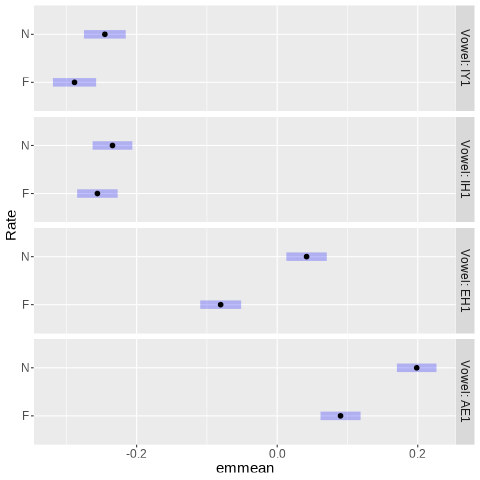

In [72]:
%%R
cex <- 1.7
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.JAW, by = "Vowel", intervals = TRUE, type = "response")

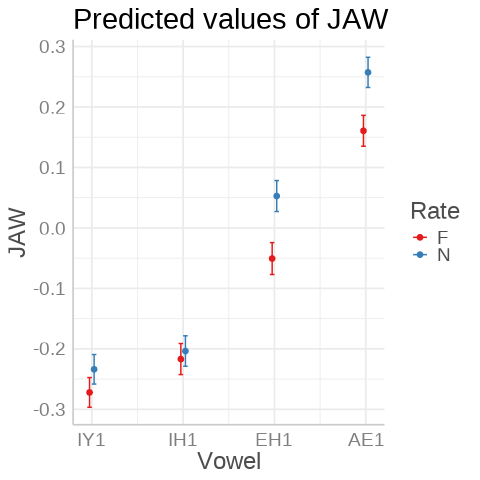

In [73]:
%%R
plot_model(m.JAW, type='pred', terms=c("Vowel","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

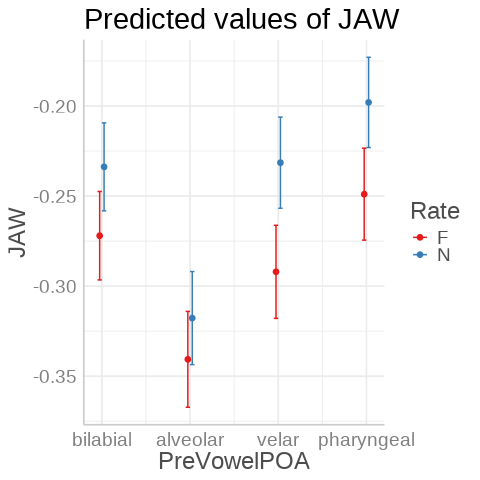

In [74]:
%%R
plot_model(m.JAW, type = "pred", terms = c("PreVowelPOA", "Rate"), show.values = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

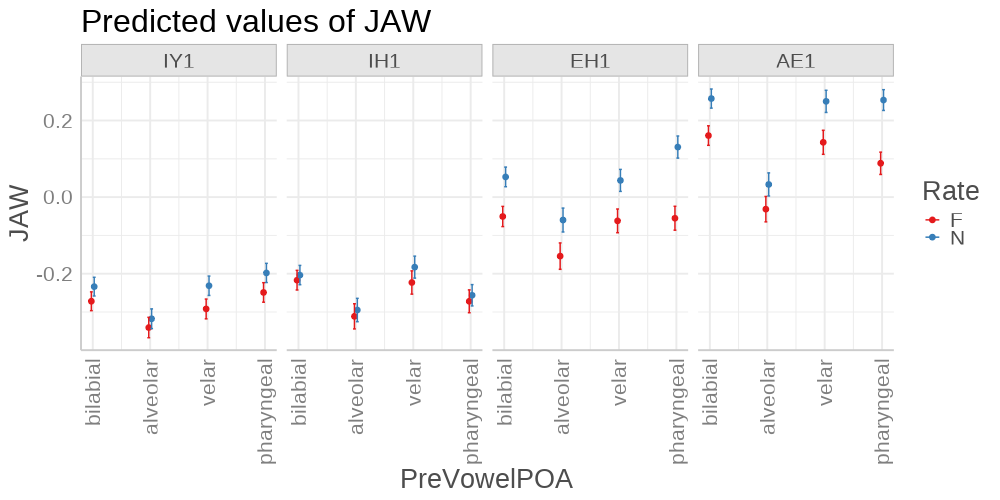

In [106]:
%%R -w 1000 -h 500
plot_model(m.JAW, type = "pred", terms = c("PreVowelPOA", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 
    #+ ylim(-0.6, 0.6)

### (2) LME model when DV: LIPS

In [76]:
%%R
m.LIPS = lmer(LIPS ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
summary(m.LIPS)

Linear mixed model fit by REML ['lmerMod']
Formula: LIPS ~ Rate * PreVowelPOA * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: 21284.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7034 -0.5636  0.0310  0.5928  5.3051 

Random effects:
 Groups   Name        Variance Std.Dev.
 Speaker  (Intercept) 0.001794 0.04236 
 Residual             0.091754 0.30291 
Number of obs: 46790, groups:  Speaker, 8

Fixed effects:
                             Estimate Std. Error t value
(Intercept)                 -0.120962   0.015322  -7.895
RateN                        0.121828   0.004184  29.116
PreVowelPOA.L               -0.008883   0.006070  -1.463
PreVowelPOA.Q               -0.004993   0.006474  -0.771
PreVowelPOA.C               -0.005589   0.006852  -0.816
Vowel.L                      0.281697   0.006998  40.253
Vowel.Q                      0.086184   0.006478  13.305
Vowel.C                     -0.013933   0.005903  -2.360
RateN:PreVowelPOA.L          0.041891

R[write to console]: 
Correlation matrix not shown by default, as p = 32 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [77]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.LIPS, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: LIPS
                           Chisq Df Pr(>Chisq)    
(Intercept)              62.3258  1  2.911e-15 ***
Rate                    847.7241  1  < 2.2e-16 ***
PreVowelPOA               3.0505  3     0.3839    
Vowel                  2795.2994  3  < 2.2e-16 ***
Rate:PreVowelPOA         63.4138  3  1.095e-13 ***
Rate:Vowel              130.0658  3  < 2.2e-16 ***
PreVowelPOA:Vowel       149.6356  9  < 2.2e-16 ***
Rate:PreVowelPOA:Vowel   51.9737  9  4.572e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [78]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.LIPS = emmeans(m.LIPS, ~ Rate|Vowel, adjust = "tukey")
pairs(em.LIPS)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46790' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46790' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0884 0.01142 Inf  -7.741 <.0001 

Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0716 0.00681 Inf -10.523 <.0001 

Vowel = EH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1771 0.00811 Inf -21.841 <.0001 

Vowel = AE1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1502 0.00612 Inf -24.523 <.0001 

Results are averaged over the levels of: PreVowelPOA 
Degrees-of-freedom method: asymptotic 


In [79]:
%%R
em.LIPS.poa = emmeans(m.LIPS, ~ Rate|PreVowelPOA|Vowel, adjust = "tukey")
pairs(em.LIPS.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46790' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46790' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.



PreVowelPOA = bilabial, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0778 0.01194 Inf  -6.511 <.0001 

PreVowelPOA = alveolar, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0559 0.00851 Inf  -6.564 <.0001 

PreVowelPOA = velar, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1173 0.04027 Inf  -2.913 0.0036 

PreVowelPOA = pharyngeal, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1027 0.01582 Inf  -6.490 <.0001 

PreVowelPOA = bilabial, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0676 0.01227 Inf  -5.509 <.0001 

PreVowelPOA = alveolar, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0751 0.00880 Inf  -8.538 <.0001 

PreVowelPOA = velar, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0843 0.01364 Inf  -6.184 <.0001 

PreVowelPOA = pharyngeal, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



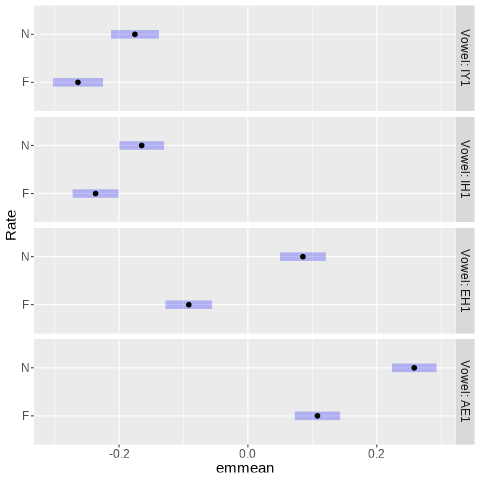

In [80]:
%%R
cex <- 1.7
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.LIPS, by = "Vowel", intervals = TRUE, type = "response")

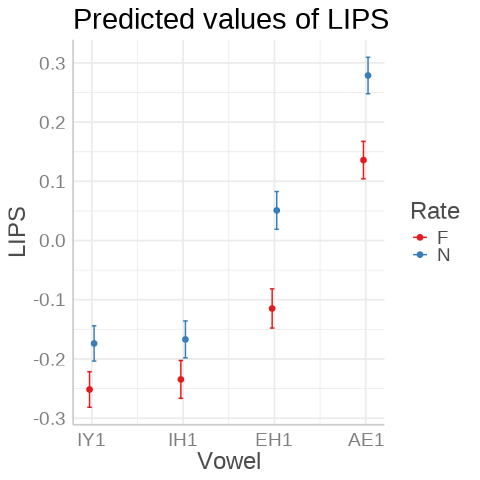

In [81]:
%%R
plot_model(m.LIPS, type='pred', terms=c("Vowel","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

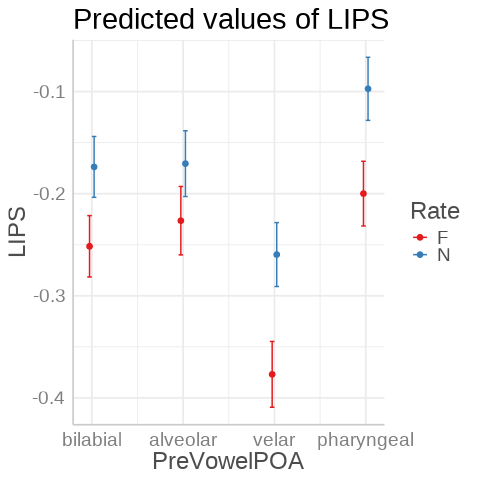

In [82]:
%%R
plot_model(m.LIPS, type = "pred", terms = c("PreVowelPOA", "Rate"), show.values = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



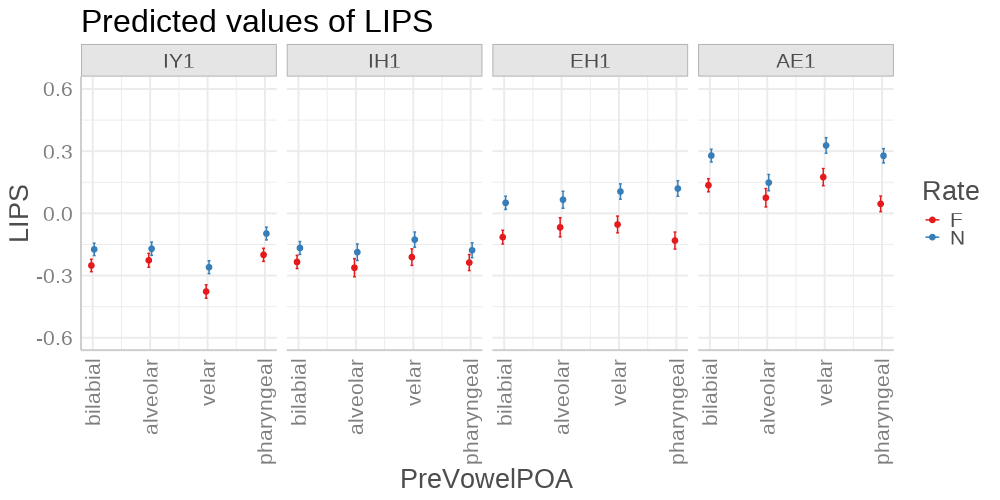

In [83]:
%%R -w 1000 -h 500
plot_model(m.LIPS, type = "pred", terms = c("PreVowelPOA", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    ylim(-0.6, 0.6)

### (3) LME model when DV: vTNG

In [84]:
%%R
m.vTNG = lmer(vTNG ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
summary(m.vTNG)

Linear mixed model fit by REML ['lmerMod']
Formula: vTNG ~ Rate * PreVowelPOA * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: 36534.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9165 -0.5989 -0.0147  0.5984  4.9098 

Random effects:
 Groups   Name        Variance Std.Dev.
 Speaker  (Intercept) 0.00375  0.06124 
 Residual             0.12713  0.35655 
Number of obs: 46790, groups:  Speaker, 8

Fixed effects:
                             Estimate Std. Error t value
(Intercept)                 -0.378364   0.021984 -17.211
RateN                        0.116322   0.004925  23.617
PreVowelPOA.L               -0.009465   0.007145  -1.325
PreVowelPOA.Q                0.118046   0.007620  15.491
PreVowelPOA.C               -0.023019   0.008065  -2.854
Vowel.L                      0.665561   0.008237  80.798
Vowel.Q                     -0.107828   0.007625 -14.142
Vowel.C                     -0.068643   0.006948  -9.880
RateN:PreVowelPOA.L         -0.010487

R[write to console]: 
Correlation matrix not shown by default, as p = 32 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [85]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.vTNG, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: vTNG
                          Chisq Df Pr(>Chisq)    
(Intercept)             296.204  1  < 2.2e-16 ***
Rate                    557.784  1  < 2.2e-16 ***
PreVowelPOA             567.068  3  < 2.2e-16 ***
Vowel                  7410.373  3  < 2.2e-16 ***
Rate:PreVowelPOA         20.421  3  0.0001389 ***
Rate:Vowel              106.042  3  < 2.2e-16 ***
PreVowelPOA:Vowel       353.303  9  < 2.2e-16 ***
Rate:PreVowelPOA:Vowel   50.935  9  7.182e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [86]:

%%R
em.vTNG = emmeans(m.vTNG, ~ Rate|Vowel, adjust = "tukey")
pairs(em.vTNG)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46790' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46790' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0208 0.01344 Inf  -1.549 0.1214 

Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1133 0.00801 Inf -14.148 <.0001 

Vowel = EH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1695 0.00955 Inf -17.761 <.0001 

Vowel = AE1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1616 0.00721 Inf -22.417 <.0001 

Results are averaged over the levels of: PreVowelPOA 
Degrees-of-freedom method: asymptotic 


In [87]:
%%R
em.vTNG.poa = emmeans(m.vTNG, ~ Rate|PreVowelPOA|Vowel, adjust = "tukey")
pairs(em.vTNG.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46790' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46790' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.



PreVowelPOA = bilabial, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0190 0.01406 Inf  -1.353 0.1762 

PreVowelPOA = alveolar, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0527 0.01002 Inf  -5.263 <.0001 

PreVowelPOA = velar, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0350 0.04740 Inf  -0.739 0.4602 

PreVowelPOA = pharyngeal, Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0235 0.01862 Inf   1.260 0.2077 

PreVowelPOA = bilabial, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1620 0.01445 Inf -11.215 <.0001 

PreVowelPOA = alveolar, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0707 0.01035 Inf  -6.828 <.0001 

PreVowelPOA = velar, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0708 0.01605 Inf  -4.410 <.0001 

PreVowelPOA = pharyngeal, Vowel = IH1:
 contrast estimate      SE  df z.ratio p.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



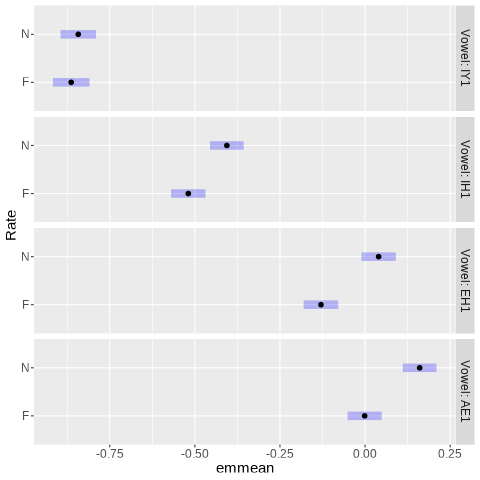

In [88]:
%%R
cex <- 1.7
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.vTNG, by = "Vowel", intervals = TRUE, type = "response")

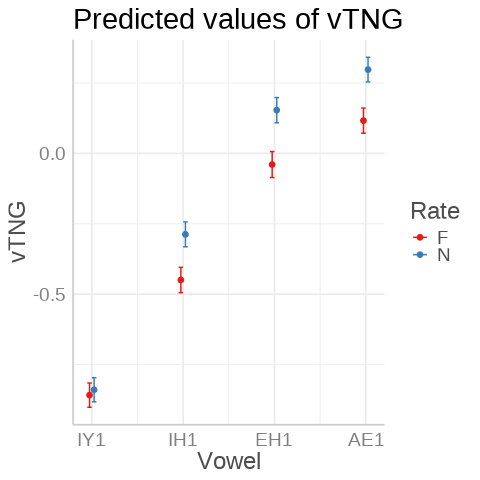

In [89]:
%%R
plot_model(m.vTNG, type='pred', terms=c("Vowel","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

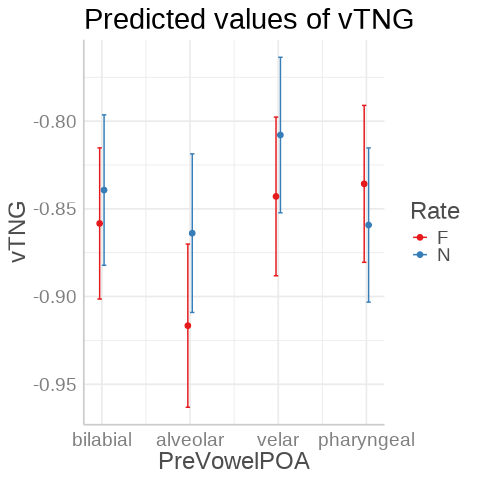

In [90]:
%%R
plot_model(m.vTNG, type = "pred", terms = c("PreVowelPOA", "Rate"), show.values = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

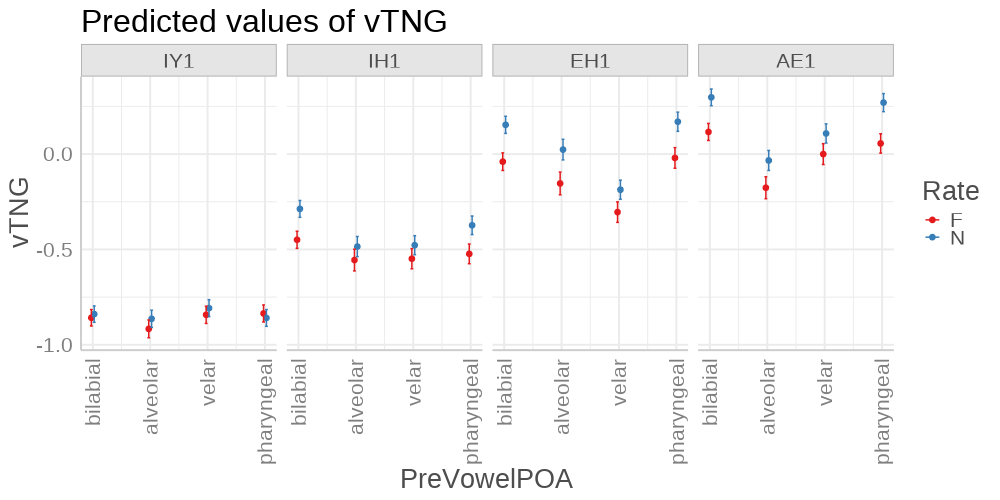

In [91]:
%%R -w 1000 -h 500
plot_model(m.vTNG, type = "pred", terms = c("PreVowelPOA", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 
    #+ ylim(-0.7, 0.6)

### (4) LME model when DV: hTNG

In [92]:
%%R
m.hTNG = lmer(hTNG ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
summary(m.hTNG)

Linear mixed model fit by REML ['lmerMod']
Formula: hTNG ~ Rate * PreVowelPOA * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: 28841.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2063 -0.6380 -0.0396  0.6028  6.4973 

Random effects:
 Groups   Name        Variance Std.Dev.
 Speaker  (Intercept) 0.003758 0.0613  
 Residual             0.107842 0.3284  
Number of obs: 46790, groups:  Speaker, 8

Fixed effects:
                             Estimate Std. Error t value
(Intercept)                 -0.321768   0.021957 -14.655
RateN                       -0.034296   0.004536  -7.560
PreVowelPOA.L                0.019366   0.006581   2.943
PreVowelPOA.Q                0.078475   0.007018  11.181
PreVowelPOA.C                0.079344   0.007428  10.682
Vowel.L                      0.271850   0.007587  35.832
Vowel.Q                     -0.110986   0.007023 -15.804
Vowel.C                     -0.003882   0.006399  -0.607
RateN:PreVowelPOA.L         -0.031443

R[write to console]: 
Correlation matrix not shown by default, as p = 32 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [93]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.hTNG, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: hTNG
                          Chisq Df Pr(>Chisq)    
(Intercept)             214.757  1  < 2.2e-16 ***
Rate                     57.158  1  4.021e-14 ***
PreVowelPOA             153.237  3  < 2.2e-16 ***
Vowel                  1312.016  3  < 2.2e-16 ***
Rate:PreVowelPOA         16.074  3  0.0010950 ** 
Rate:Vowel               89.685  3  < 2.2e-16 ***
PreVowelPOA:Vowel       226.326  9  < 2.2e-16 ***
Rate:PreVowelPOA:Vowel   32.418  9  0.0001686 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [94]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.hTNG = emmeans(m.hTNG, ~ Rate|Vowel, adjust = "tukey")
pairs(em.hTNG)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46790' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46790' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0536 0.01238 Inf  4.330  <.0001 

Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0715 0.00738 Inf  9.694  <.0001 

Vowel = EH1:
 contrast estimate      SE  df z.ratio p.value
 F - N      0.0312 0.00879 Inf  3.553  0.0004 

Vowel = AE1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0192 0.00664 Inf -2.890  0.0039 

Results are averaged over the levels of: PreVowelPOA 
Degrees-of-freedom method: asymptotic 


In [95]:
%%R
em.hTNG.poa = emmeans(m.hTNG, ~ Rate|PreVowelPOA|Vowel, adjust = "tukey")
pairs(em.hTNG.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46790' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46790' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46790)' or larger];
but be warned that this may result in large computation time and memory use.



PreVowelPOA = bilabial, Vowel = IY1:
 contrast  estimate      SE  df z.ratio p.value
 F - N     2.17e-02 0.01295 Inf  1.674  0.0940 

PreVowelPOA = alveolar, Vowel = IY1:
 contrast  estimate      SE  df z.ratio p.value
 F - N     3.84e-02 0.00923 Inf  4.166  <.0001 

PreVowelPOA = velar, Vowel = IY1:
 contrast  estimate      SE  df z.ratio p.value
 F - N     1.14e-01 0.04366 Inf  2.622  0.0087 

PreVowelPOA = pharyngeal, Vowel = IY1:
 contrast  estimate      SE  df z.ratio p.value
 F - N     3.98e-02 0.01715 Inf  2.322  0.0203 

PreVowelPOA = bilabial, Vowel = IH1:
 contrast  estimate      SE  df z.ratio p.value
 F - N     8.09e-02 0.01330 Inf  6.081  <.0001 

PreVowelPOA = alveolar, Vowel = IH1:
 contrast  estimate      SE  df z.ratio p.value
 F - N     6.75e-02 0.00954 Inf  7.079  <.0001 

PreVowelPOA = velar, Vowel = IH1:
 contrast  estimate      SE  df z.ratio p.value
 F - N     4.24e-03 0.01478 Inf  0.287  0.7741 

PreVowelPOA = pharyngeal, Vowel = IH1:
 contrast  estimate      SE

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



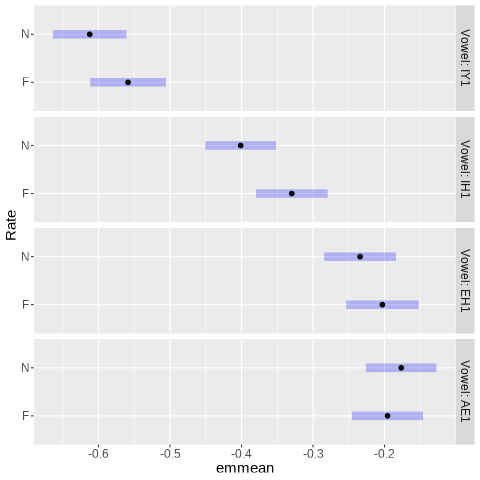

In [96]:
%%R
cex <- 1.7
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.hTNG, by = "Vowel", intervals = TRUE, type = "response")

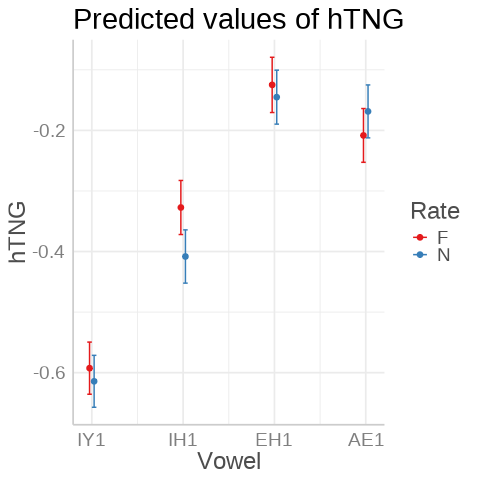

In [97]:
%%R
plot_model(m.hTNG, type='pred', terms=c("Vowel","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

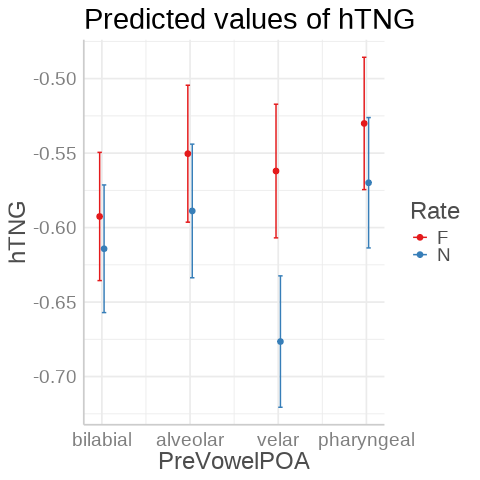

In [98]:
%%R
plot_model(m.hTNG, type = "pred", terms = c("PreVowelPOA", "Rate"), show.values = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

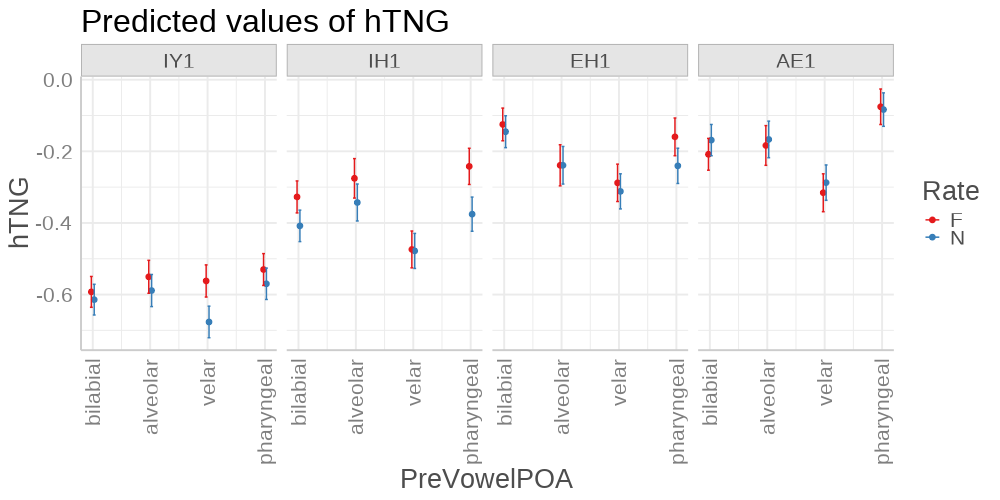

In [99]:
%%R -w 1000 -h 500
plot_model(m.hTNG, type = "pred", terms = c("PreVowelPOA", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 
    #+ ylim(-1, 1)